# Getting Acquainted

The data was collected from Kaggle @ https://www.kaggle.com/zynicide/wine-reviews

### This notebook is split into 4 sections covering the analysis of the wine dataset:

1) Getting Acquainted & Purpose

2) Prepping Data

3) Charting Points to Country relation

4) Charting Variety to Country relation

5) Charting Variety to Rating relation

6) Creating a Pricing Model

7) Conclusion and Final Thoughts

### Purpose: Exploring Feature Impacts on Wine Pricing

In this notebook I am going to be exploring which features best contribute to a wine's price and create a predictive model from it. This will be guided with domain knowledge from the book Wine Folly, (a sommelier's guide to tasting), and combined with NLP techniques and statistical analysis to determine the best features.

#### Domain Guidance:

According to Wine Folly, there are several factors that influence wine prices; country of origin and vintage year made, winery history and reputation, and the taster's reputation, review and point assignment to the wine. Additionally, points are allocated based on how a wine typifies it's variety. Like a dog in a dog show, the winning Aussie isn't the one that looks like a poodle.

Wine Folly also mentions that a wine that is given a higher score can ultimately impact the future price of the wine by boosting the reputation of the winery and creating a demand shift for the wine. Because of this, points is something that will need to be studied and better understood in this process. 

#### Explantion:
Wine is a rather illiquid asset 

### Prepping Dataframe

In [1]:
## For this notebook, we will first import the dataset from the csv file and then check to see if there are Null values
import pandas as pd 
import os 

## loading dataframe
data = pd.read_csv("winemag-data_first150k.csv", index_col = False)

##Checking for null values & printing first 3 lines of dataframe
print(data.isnull().sum())

data.head(3)

Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


###### What will be removed:

Because the focus of this is to see the impact of points, country, variety, and descriptions on price; I can safely drop the Unamed 0, designation, and region_2 column.

I know you may be wondering why I did not also include region_1, this is because region_1 

In [2]:
data = data.drop(['Unnamed: 0','region_2','designation'], axis=1)

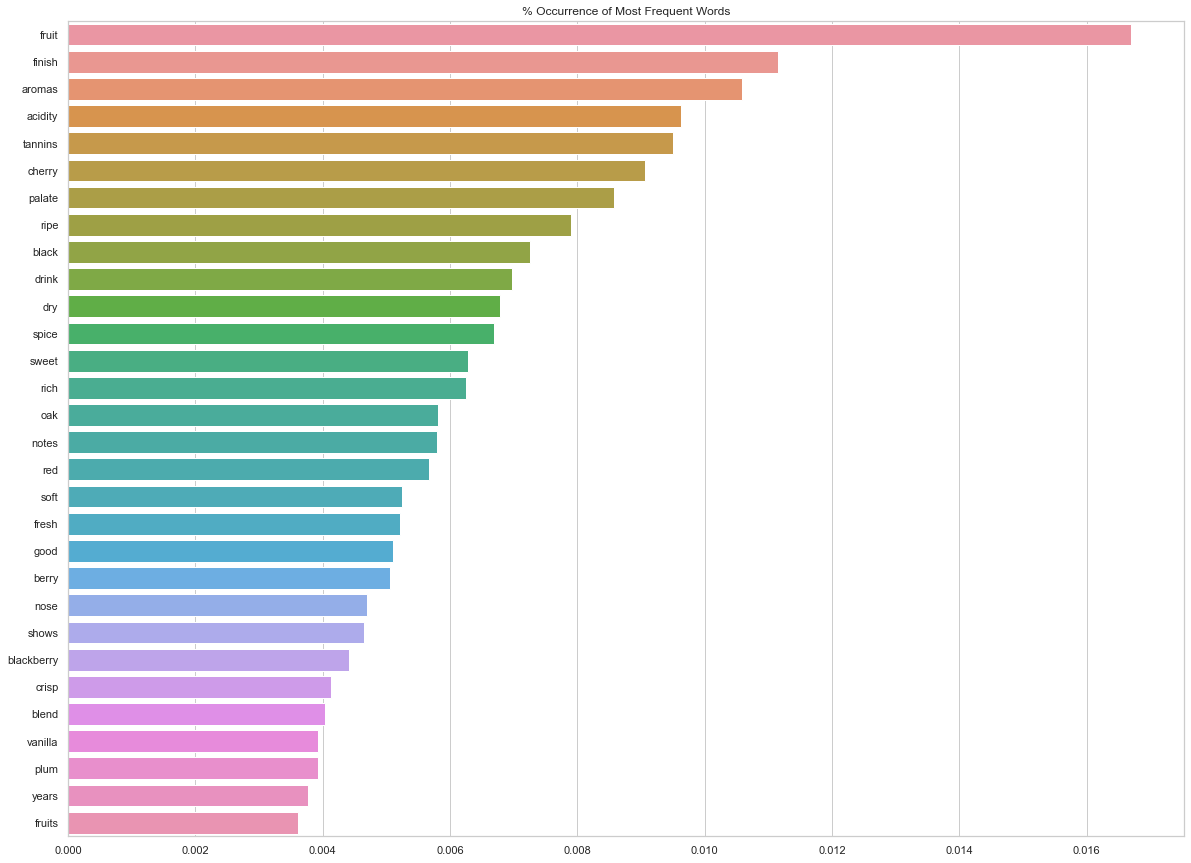

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

# set seaborn style 
plt.figure(figsize=(20,15))
sns.set(style="whitegrid")


newStopWords = ['wine','flavors']
stopwords = stopwords.words('english')
stopwords.extend(newStopWords)
stopwords = set(stopwords)

detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

data["cleaned_description"] = data["description"].apply(clean_description)

word_occurrence = data["cleaned_description"].str.split(expand=True).stack().value_counts()

total_words = sum(word_occurrence)

# plot most common words 

top_words = word_occurrence[:30]/total_words

ax = sns.barplot(x = top_words.values, y = top_words.index)

# Setting title 
ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

In [4]:
data.head()

,country,description,points,price,province,region_1,variety,winery,cleaned_description
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,tremendous varietal hails oakville aged three ...
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,mac watson honors memory made mother tremendou...
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,spent months new french oak incorporates fruit...
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,top la bégude named highest point vineyard fee...


In [5]:
### Finding the weights of country wine production

In [10]:
country_by_variety = data[['country','variety']].dropna(how='any')

# Only consider varieties that have atleast 5000 instances
country_by_variety = country_by_variety.filter(lambda x: (x["variety"].count() >= 5000))

top_10_varietals = country_by_variety['variety'].groupby(country_by_variety['country']).value_counts(n)

pd.set_option('display.max_rows', None)
top_10_varietals

TypeError: 'function' object is not iterable

### Price by Country

Looking at the chart above there are a couple interesting findings. For example, why does Hungary have such a large range compared to all the other countries

In [ ]:
prices_by_country = data[["price", "country"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
val = prices_by_country["price"].quantile(0.98)
prices_by_country = prices_by_country[prices_by_country["price"] < val]

# Only consider countries where at least 100 wines have been reviewed
prices_by_country = prices_by_country.groupby("country").filter(lambda x: (x["price"].count() >= 100))

# Creating a boxplot
plt.figure(figsize=(20,15))
ax = sns.boxplot(x="country", y = "price", data=prices_by_country)

# Setting title 
ax.set_title("Wine Prices by Country")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

In [ ]:
prices_by_variety = data[["price", "variety"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
val = prices_by_variety["price"].quantile(0.98)
prices_by_variety = prices_by_variety[prices_by_variety["price"] < val]

# Only consider varieties where at least 500 wines have been reviewed
prices_by_variety = prices_by_variety.groupby("variety").filter(lambda x: (x["price"].count() >= 500))

# Creating a boxplot
plt.figure(figsize=(20,15))
ax = sns.boxplot(x="variety", y = "price", data=prices_by_variety)

# Setting title 
ax.set_title("Wine Prices by Variety")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Variety", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')


plt.show()

In [ ]:
ratings_by_price = data[["price", "points"]]

# Remove all data greater than the 98th percentile
val = prices_by_variety["price"].quantile(0.98)
ratings_by_price = ratings_by_price[ratings_by_price["price"] < val]


ax = sns.lmplot(x = "price", y = "points", data = ratings_by_price, height = 10, aspect = 1)

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Price in USD", ylabel = "Wine Rating")

plt.show()

### Creating a rating system
Reading through the book Wine Folly as well as looking on the Wine Enthusiast website, I came across an excellent point system that I will use to categorize the groups. You can read more about it here: https://winefolly.com/tips/wine-ratings-explained/

TLDR:

The wine rating system was developed back in the 80s which scored wines based on production quality and typicity, (how much the traits of the particular wine typify the style and region its from). Another way to think of it is like a dog show, the winner is the dog which explifies its breed. Any unique features that are not typical will score it lower on the point system. 

Ratings
95 - 100    The benchmark examples or 'Classic'
90 - 94     Superior to Exceptional
85 - 90     Good to veru good
80 - 84     Above average to good
70 - 79     Flawed wines and taste average
60 - 69     Wines are flawed and not recommended but drinkable
50 - 59     Wines are flawed and undrinkable

Interestingly, the dataset has no wines with a score under 80 which alludes again that only the better wines are scored. Additionally there are a couple notable flaws in this system: wine rating intervals vary depending on the different rating sites. For example:

Wine & Spirits magazine says 86 - 89 is highly recommended, whereas Wine Enthusiast Magazine says 85 - 89 is very good. Because of this, I am using Wine Folly's system because the site is used as a training resource for sommeliers, thus offering a solid 3rd party system.

I will be adopting this same point interval system for my classes 0 - 4.

##### Note for the rating system:
Due to issues surrounding biases that arise in self rating systems 

In [ ]:
# Converting Points to Classes 

# Note: I found that I had to adjust the class ranges below in order to capture the 100point wines and ensure none were left out.
def points_to_class(points):
    if points in range(79,85):
        return 0
    elif points in range(84,90):
        return 1
    elif points in range(89,95):
        return 2
    elif points in range(94,101):
        return 3
    else:
        return 4
    
data['rating'] = data['points'].apply(points_to_class)

In [ ]:
data['rating'].value_counts()

In [ ]:
# As expected the data is imbalanced.
# Interestingly, this falls inline with the expected results
# Wine Folly's rating bell curve shows that a majority of the ratings fall between 87 - 89 points
# as seen below and in the link provided earlier

sns.histplot(data = data, x = 'points', stat = 'density', binwidth=1, bins=20)

In [ ]:
#Now creating a new column with our newly designated rating classes as "rating".
data["rating"] = data["points"].apply(points_to_class)
data.head()

### Diving deeper with Sentiment, Word Count, and Sentence Length

In [ ]:
from textblob import TextBlob
#Creating a sentiment column
data['sentiment'] = data['cleaned_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Creating words and Sentence length columns
data['word_count'] = data['cleaned_description'].apply(lambda x: len(str(x).split()))
data['review_len'] = data['cleaned_description'].astype(str).apply(len)

data.head()

In [ ]:
# Given our data is mainly the higher end wines and those that are score, I'd assume there would be a skwew in the sentiment
# Clearly below, we can see there is a much higher concentration of positive vs negative sentiment.

plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(data['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

In [ ]:
# Additionally, looking at how sentiment is distributed over the points and the rating system I created
# It is clear that the average positive sentiment per-point/rating class is higher for the highly rated wines.

polarity_avg = data.groupby('points')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Points', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Points Distribution', fontsize=50)
plt.show()

In [ ]:
## This chart confirms that higher rated wines will have more positive sentiment in the reviews ##

polarity_rating = data.groupby('rating')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Points', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Points Distribution', fontsize=50)
plt.show()

In [ ]:
### Lets look at how sentiment is towards the most rated countries.
sentiment_by_country = data[["sentiment", "country"]].dropna(how = "any")

# Only consider countries where at least 100 wines have been reviewed
sentiment_by_country = sentiment_by_country.groupby("country").filter(lambda x: (x["sentiment"].count() >= 100))

# Creating a boxplot
plt.figure(figsize=(20,15))
ax = sns.boxplot(x="country", y = "sentiment", data=sentiment_by_country)

# Setting title 
ax.set_title("Wine Sentiment by Country")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Sentiment")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

In [ ]:
country_polarity = sentiment_by_country.groupby('country')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('country', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Points Distribution', fontsize=50)

plt.axhline(sentiment_by_country['sentiment'].mean(), color='r',fillstyle = 'full', linestyle='dashed', linewidth=3)
plt.axhline(sentiment_by_country['sentiment'].median(), color='g',fillstyle = 'full', linestyle='dashed', linewidth=3)

plt.show()

In [ ]:
### I want to see the statistics between countries and their average and median rating in order to get a better idea
### as to how these countries are differentiated ###

## Looking at average rating class between countries ##
rating_by_country = data[["rating", "country"]].dropna(how = "any")

## Only consider countries where at least 100 wines have been reviewed ##
rating_by_country = rating_by_country.groupby("country").filter(lambda x: (x["rating"].count() >= 100))

## Creating barplot, grouping the ratings by countries and ratings and creating an average ##
polarity_rating = rating_by_country.groupby('country')['rating'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Country', fontsize=45)
plt.ylabel('Average rating', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Rating per Country Distribution', fontsize=50)

## Mean of country ratings ##
plt.axhline(rating_by_country['rating'].mean(), color='r',fillstyle = 'full', linestyle='dashed', linewidth=3)

## Median of country ratings ##
plt.axhline(rating_by_country['rating'].median(), color='g',fillstyle = 'full', linestyle='dashed', linewidth=3)

plt.show()

### Points of interest

In the charts above, I'd like to point out several points of interest.

First, there are only 6 countries that had an average rating higher than the group's average. These are in order; Austria, Canada, France, Germany, Italy, and Portugal.

Canada stands out as interesting because a common belief in the wine industry is that "old world" wines will generally be rated higher since these are generally where the typify of the varietal type was developed and imitations of the same varietal types are judged on these. This I'll explore further to verify its accuracy.

Second, of the 12 countries that lay above the median line (green), 6 of them

In [ ]:

#Looking at average rating class between Provinces.
rating_by_province = data[["rating", "province"]].dropna(how = "any")

# Only consider Provinces where at least 500 wines have been reviewed
rating_by_province = rating_by_province.groupby("province").filter(lambda x: (x["rating"].count() >= 500))

polarity_rating = rating_by_province.groupby('province')['rating'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Province', fontsize=45)
plt.ylabel('Average rating', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Rating per Province Distribution', fontsize=50)
plt.axhline(rating_by_province['rating'].mean(), color='r',fillstyle = 'full', linestyle='dashed', linewidth=3)
plt.show()

In [ ]:
## Digging deeper, I want to see which is the most common wine with atleast 500 ratings.
## I am trying to establish if there is oversaturation in certain varieties which leads to a rating drag.
## Below for example, we see that the top varietal type is Chardonnay with nearly 14,500 instances in the dataset

## what we also can see is that when grouping these by its rating, no Chardonnay crack into the highest rating interval.
## In the wine world today, this pretty

data_by_variety = data[["rating","variety"]].dropna(how = "any")

# Only consider Provinces where at least 500 wines have been reviewed
data_by_variety = data_by_variety.groupby("variety").filter(lambda x: (x["rating"].count() >= 500))

print(data_by_variety["variety"].value_counts().head(5))

print(data_by_variety.groupby('rating')["variety"].value_counts())

In [ ]:
#Looking at average rating class between Varieties.
rating_by_variety = data[["rating", "variety"]].dropna(how = "any")

# Only consider Provinces where at least 500 wines have been reviewed
rating_by_variety = rating_by_variety.groupby("variety").filter(lambda x: (x["rating"].count() >= 500))

polarity_rating = rating_by_variety.groupby('variety')['rating'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Variety', fontsize=45)
plt.ylabel('Average rating', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Rating per Variety Distribution', fontsize=50)
plt.axhline(rating_by_variety['rating'].mean(), color='r',fillstyle = 'full', linestyle='dashed', linewidth=3)
plt.show()

### Comparing High scoring Countries vs Low Scoring countries using weighted average

From the chart above we can see that there is an average rating cut off is just below 1.2. But this does not take into account the respresentive quantity of ratings in each country. It is important to take this into account because a country who produces alot of wine can be brough closer to the average.

To break this down further, I will need to find the quantities of the varieties by each country, and then calculated the weighted average points and ratings by country. I could break this down futher and even find the weighted average by variety as well.

In [ ]:
weighted_features = data[['country','province','points','rating','variety']]
wf = weighted_features.groupby(['country'].filter(lambda x: (x['points'].count() >= 100)))
df

In [ ]:
points_by_x = data[['points','country', 'variety', 'province']].dropna(how = "any")

# Only consider countries where at least 100 wines have been reviewed
points_by_x = points_by_x.groupby(['country', 'variety', 'province']).filter(lambda x: (x["points"].count() >= 100))

a_df = points_by_x.loc[points_by_x['country'] == 'Argentina']

#weight of points per country
argentina_point_weights = a_df.points.value_counts() / a_df.points.count()

#weight of varieties per country
argentina_variety_weights = a_df.variety.value_counts() / a_df.variety.count()

vwdf = pd.DataFrame(argentina_variety_weights, columns = ['wt', 'variety'])
#weight of ratings per country

#weight of sentiment per country



In [ ]:
argentina_variety_weights

In [ ]:
df_f = data[['points','country', 'variety', 'province']].dropna(how = "any")

df_f = df_f.groupby(['country', 'variety', 'province']).filter(lambda x: (x["points"].count() >= 100))

In [ ]:
df_f = data[['points','country', 'variety', 'province']].dropna(how = "any")
df_f = df_f.groupby(['country', 'variety', 'province']).filter(lambda x: (x["points"].count() >= 100))
df_f.variety.value_counts()/df_f.variety.count()

In [ ]:
df_f.province.value_counts()/df_f.province.count()

In [ ]:
df_f.country.value_counts()/df_f.country.count()

In [ ]:
#Normalize columns to better understand country/province relationships with varieties, ratings, provinces and sentiment
def find_weights(df):
     
    for features in df[]:
        features = df[['country','province','points','rating','variety']].dropna(how = "any")
        
    for name in df['country']:
        
        sum_var_occur = df.loc[df['country'] == name].value_counts()
        print(sum_var_occur)
        
find_weights(data)

In [ ]:
  country_name_df = 
    country_name_df_weights = country_name_df.variety.value_counts() / country_name_df.variety.count()
    print(country_name_df_weights)

In [ ]:
vwdf.reset_index(inplace=True)
vwdf =vwdf.rename(columns = {'index' : 'variety', 'variety':'wt', 'wt':'na'})

vwdf

In [ ]:
vwdf= vwdf.drop(['na'], axis=1)
vwdf

In [ ]:
data.head()

In [ ]:
def argentina_weights_to_variety(variety):
    if variety in vwdf['variety']:   
        return vwdf['wt']
    else:
        return 0
    
a_df['v_wt'] = a_df['variety'].apply(argentina_weights_to_variety)

In [ ]:
### Lets look at the weight of the frequencies between the high rating countries and the low rating countries
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum()/w.sum()
    except ZeroDivisionError:
        return d.mean()

In [ ]:
a_df.points.count()


#### Getting Granular: Wine Points by Variety

As previously mentioned when creating a rating class system, points are scored based on how the wine typifies its variety. Thus it is prudent to also look at how the point and sentiment distribution looks by variety as well to gain a better understanding of the data.

In [ ]:
points_by_variety = data[["points", "variety"]].dropna(how = "any")

# Only consider varieties where at least 500 wines have been reviewed
points_by_variety = points_by_variety.groupby("variety").filter(lambda x: (x["points"].count() >= 500))

# Creating a boxplot
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='variety', y = 'points', data=points_by_variety)

# Setting title 
ax.set_title("Wine Points by Variety")

ax.set(xlabel = "Wine Variety", ylabel = "Wine Points")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')


plt.show()

In [ ]:
#fix this in plotly

variety_sentiment = data.groupby('variety')['sentiment'].mean().plot(kind='bar', figsize=(70,30))
plt.xlabel('Variety', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Variety Distribution', fontsize=50)
plt.show()

In [ ]:
import pandas as pd
import requests
import time
import numpy as np
import nltk
import pyLDAvis
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
pyLDAvis.enable_notebook()

In [ ]:
df.shape

In [ ]:
df['country'] =df['country'].astype('category')
df['province'] =df['province'].astype('category')
df['variety'] =df['variety'].astype('category')
df['winery'] =df['winery'].astype('category')



df.dtypes

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['country_cat'] = le.fit_transform(df['country'])

dummy_varieties = pd.get_dummies(df['variety'])

df = pd.concat([df, dummy_varieties], axis=1)
df.describe()

In [ ]:
#Looking at the specific stats between countries.
#This will also be used to eliminate outlier countries who's sum point counts are below the average.

#defining stats function with .describe() and .skew()
def stats(x):
    results = pd.concat([x.describe(), x.skew()], axis=1)
    print(results)

stats(df[['country', 'points']].groupby('country'))

In [ ]:
from tqdm import tqdm

def corr_heatmap(df):
    corr = df.corr()
    fig = plt.figure(figsize=(25,20))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", linewidths=0.5, annot=True)
    ax.set_title("Correlation matrix")
    
    return ax

corr_heatmap(df)


In [ ]:
df_nums = df.drop(['province', 'variety', 'winery',
       'description', 'rating_description_str', 'tokenized', 'lemmatized',
       'lemma_str'], axis=1)
import ppscore as pps
 

def heatmap(df):
    fig = plt.figure(figsize=(70,50))
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="coolwarm", linewidths=0.5, annot=True)
    ax.set_title("PPS matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    return ax

matrix = pps.matrix(df_nums)

matrix

#### Review of the Correlation and PPS tables
The Correlation and PPS tables above reveal some interesting findings about the data:

1) the relation between countries and points
2) 

### TF-IDF-NMF Model

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

In [ ]:
%%time

nmf = NMF(n_components=15, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

### LDA Model

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(new_df['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
             
display_topics(lda_model, tf_feature_names, no_top_words)


In [ ]:
pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)

### Comparing topics generated between LDA and NMF models:

Looking over the two sets if topics, it appears the NMF model generates much better overall topic descriptions than the LDA model based a sommelier book called Wine Folly which offer descriptions on wines and how to translate the different descriptions. (will be creating a vectorization model from this later)

In [ ]:


nmf_topic_values = nmf.transform(tfidf)
df['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
df['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'flavor apple citrus acidity wine crisp peach white finish fruit',
             1: 'fruit seem noir pinot new go acid perfume bit acidic',
             2: 'cherry black tannin cabernet blend blackberry finish dry merlot drink',
             3: 'wine import vineyard year vintage one grape time intense pie',
             4: 'cherry flavor raspberry dry little cola spice simple pinot red',
             5: 'flavor finish palate fruit berry plum aroma big feel herbal',
             6: 'wine fruit spice aroma aromas berry mouth note bright offer',
             7: 'flavor wine oak sweet rich good blackberry best like show',
             8: 'finish flavor style palate nose sweet light candy hint note',
             9: 'wine fruit acidity ripe age tannin year flavor rich structure'}
df['lda_topics'] = df['lda_topics'].map(lda_remap)
nmf_remap = {0: 'finish berry palate nose plum aroma herbal note flavor feel',
             1: 'oak vanilla toast pineapple chardonnay butter rich flavor creamy acidity',
             2: 'wine fruit age year ripe structure wood rich well tannin',
             3: 'pinot cherry noir raspberry cola silky flavor red drink spice', 
             4: 'acidity fresh light fruity wine bright red drink crisp attractive',
             5: 'sweet soft simple taste like flavor candy wine little jammy',
             6: 'cabernet blend sauvignon merlot franc syrah verdot petit blanc sangiovese',
             7: 'apple citrus white peach green crisp pear lemon clean lime',
             8: 'black cherry spice tannin dark pepper chocolate offer blackberry licorice',
             9: 'dry blackberry good currant flavor tannic show drink tannin wine'}
df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)

In [ ]:
df.head()

### Checkpoint

In [ ]:
df.sort_values(by=['points'])

In [ ]:
nmf_x = df['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

In [ ]:
df_low_points = df.loc[(df['points']==80) | (df['points']==87)]
nmf_low_x = df_low_points['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Low Points (1 & 2)", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

In [ ]:
df_high_ratings = df.loc[(df['points']==88) | (df['points']==100)]
nmf_high_x = df_high_ratings['nmf_topics'].value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("NMF Topic Distribution for High Points (3 & 4)", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

In [ ]:
wines.head()

In [ ]:
wines_new= wines.drop(['lemmatized', 'points'], axis=1)

In [ ]:
new_df = pd.concat([df, wines_new], axis=1)

In [ ]:
new_df.head()

In [ ]:
x_rating = new_df.points.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Point Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Wine Points', fontsize=50)
plt.xticks(fontsize=40)

In [ ]:
letter_avg = new_df.groupby('points')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Points', fontsize=35)
plt.ylabel('Count of Letters in Points', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Points Distribution', fontsize=40)
plt.show()

In [ ]:
word_avg = new_df.groupby('points')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Points', fontsize=35)
plt.ylabel('Count of Words in Points', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Points Distribution', fontsize=40)
plt.show()

In [ ]:
correlation = new_df[['points','sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [ ]:
word = new_df['lemmatized']

words_nmf = new_df['nmf_topics']

words_lda = new_df['lda_topics']

In [ ]:
mostcommon = FreqDist(word).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
mostcommon = FreqDist(words_nmf).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
mostcommon = FreqDist(words_lda).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
new_df = new_df.drop(['province', 'variety'], axis=1)
new_df.to_csv('winesft_w_models.csv', index=False, encoding='utf-8')

In [ ]:
new_df.loc[new_df['points'] == 100]

### model 2

In [ ]:
plt.figure(figsize=(200,50))
plt.xticks(fontsize=40)
ax = sns.boxplot(x="country", y="points", data=new_df)

In [ ]:
new_df

In [ ]:
perfect_sen = new_df.loc[new_df['sentiment'] == 1]
plt.figure(figsize=(100,50))
plt.xticks(fontsize=40)
ax = sns.boxplot(x="country", y="points", data=perfect_sen)